# **Pre Classification Analysis** 

In [44]:
import sys
sys.path
sys.path.append('c:\\Users\\3leso\\Documents\\Elena\\Uni\\MasterThesis\\MasterThesis_final\\code\\preprocessing')

### Set file paths

In [45]:
file_comments = "../../../../data/reddit/NeutralPolitics_comments.zst"
file_submissions = "../../../../data/reddit/NeutralPolitics_submissions.zst"

subreddit_here = "NeutralPolitics"
subreddit = "NeutralPolitics"


output_path = f"output/{subreddit_here}_new_preprocessing_com_rep.csv"



In [46]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain

import zstandard
import io

from sklearn.model_selection import train_test_split
from scipy import sparse
import random
from itertools import combinations
import collections
import multiprocessing
import copy
import time
#import gurobipy
#from gurobipy import *

pd.options.mode.chained_assignment = None

In [47]:
from preprocessing_functions import import_subreddit
from preprocessing_functions import aggregate_interactions_directed
from preprocessing_functions import get_counts_and_shares
from preprocessing_functions import find_max
from preprocessing_functions import build_undirected
from preprocessing_functions import get_submissions
from preprocessing_functions import get_comments_and_replies
from preprocessing_functions import assign_types
from preprocessing_functions import find_relevant_submissions
from preprocessing_functions import plot_submissions_comments
from preprocessing_functions import match_reply_comment_submission
from preprocessing_functions import preprocess_texts
from preprocessing_functions import import_merge_predicted_labels

***

## **Data Import**

In [48]:
# import data
data_comments = import_subreddit(file_comments)
data_submissions = import_subreddit(file_submissions)


In [49]:
# make df
df_comments = pd.DataFrame(data_comments)
df_submissions = pd.DataFrame(data_submissions)

In [50]:
# submissions
# filter relevant columns

submissions = get_submissions(df_submissions)

Nr. of pulled submissions 22258


In [51]:
# comments
# select relevant columns only

df_comments_replies = get_comments_and_replies(df_comments)

Nr. of pulled comments & replies 578041


In [52]:
# assign types and extract them to separate dfs
comments, replies = assign_types(df_comments_replies, submissions)

Nr. of comments 99234
Nr. of replies 94724


### Filter relevant submissions

* relevant = above subreddit-average number of comments
* relevant_comments: those with a parent, that is in relevant_submissions

In [53]:
relevant_submissions = pd.DataFrame(comments.groupby('parent_id')['id'].count()).reset_index().rename(columns={'parent_id' : 'submission_id', 'id' : 'count'})
print(relevant_submissions['count'].mean())
relevant_submissions
# get nr of submissions, for which I do have comments --> 29.304


4.721157048384795


,submission_id,count
0,1002iet,2
1,100ap9z,2
2,100o2j,14
3,100udp1,2
4,101xz3,1
...,...,...
21014,zxfpo,34
21015,zxo6ei,2
21016,zy8kqu,2
21017,zyza2,1


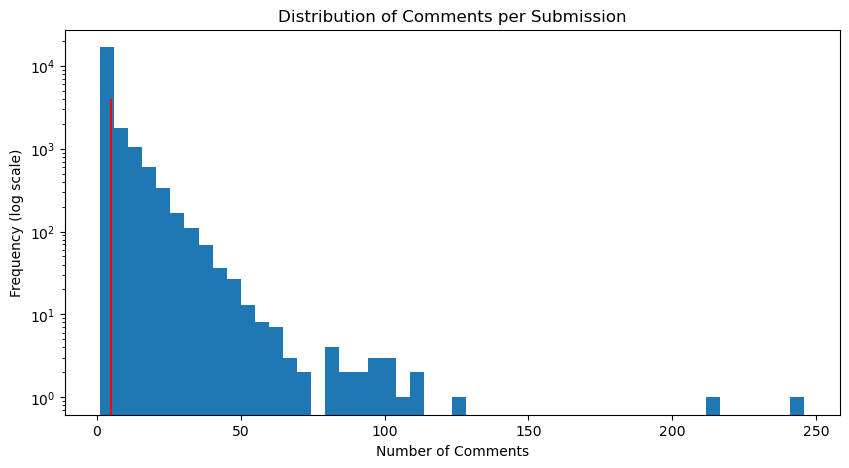

In [54]:
# Histogram
plt.figure(figsize=(10, 5))
plt.hist(relevant_submissions['count'], bins=50)
plt.vlines((relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=4000)

plt.yscale('log')
#plt.xscale('log')
plt.xlabel("Number of Comments")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Comments per Submission")
plt.show()


In [55]:
plt_data = pd.DataFrame(relevant_submissions['count'].value_counts()).rename(columns={'count' : 'class_count'}).reset_index().rename(columns={'count' : 'comment_count'}).sort_values(by = "comment_count").reset_index(drop=True)

plt_data['log_com_count'] = plt_data['comment_count'].apply(lambda x: np.log10(x))
plt_data['log_class_count'] = plt_data['class_count'].apply(lambda x: np.log10(x))
plt_data

,comment_count,class_count,log_com_count,log_class_count
0,1,5056,0.000000,3.703807
1,2,5987,0.301030,3.777209
2,3,4531,0.477121,3.656194
3,4,752,0.602060,2.876218
4,5,478,0.698970,2.679428
...,...,...,...,...
74,106,1,2.025306,0.000000
75,113,2,2.053078,0.301030
76,125,1,2.096910,0.000000
77,212,1,2.326336,0.000000


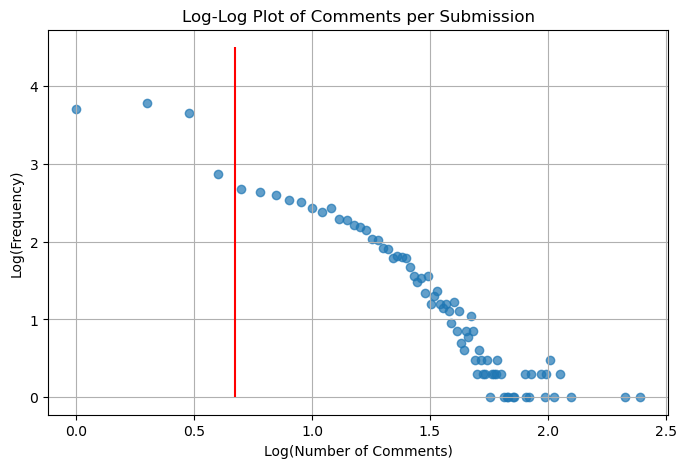

In [56]:
plt.figure(figsize=(8, 5))
plt.scatter(plt_data['log_com_count'], plt_data['log_class_count'], alpha=0.7)
plt.vlines(np.log10(relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=4.5)

plt.xlabel("Log(Number of Comments)")
plt.ylabel("Log(Frequency)")
plt.title("Log-Log Plot of Comments per Submission")
plt.grid(True)
plt.show()

Text(0, 0.5, 'Nr. of submissions')

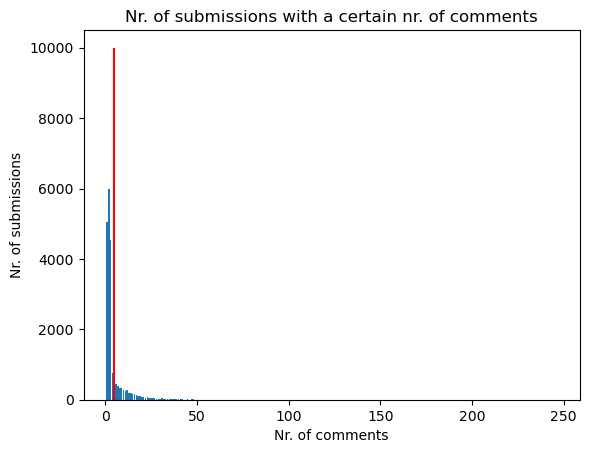

In [57]:
# excluding three submissions with > 100 comments

plt.bar(x = plt_data['comment_count'], height = plt_data['class_count'])
plt.vlines(relevant_submissions['count'].mean(), colors="red", ymin = 0, ymax=10000)
plt.title("Nr. of submissions with a certain nr. of comments")
plt.xlabel("Nr. of comments")
plt.ylabel("Nr. of submissions")

Text(0, 0.5, 'Nr. of submissions')

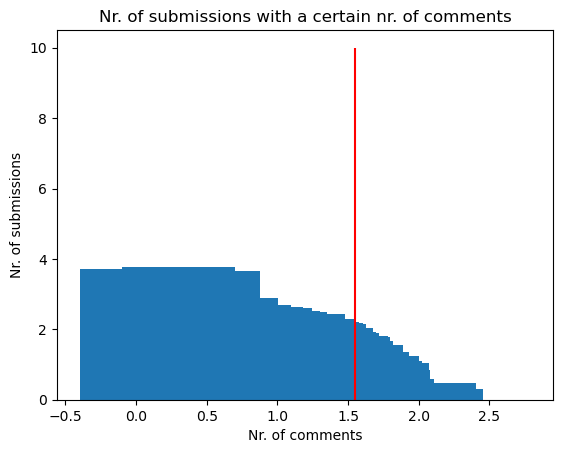

In [58]:
# excluding three submissions with > 100 comments

plt.bar(x = plt_data['log_com_count'], height = plt_data['log_class_count'])
plt.vlines(np.log(relevant_submissions['count'].mean()), colors="red", ymin = 0, ymax=10)
plt.title("Nr. of submissions with a certain nr. of comments")
plt.xlabel("Nr. of comments")
plt.ylabel("Nr. of submissions")

In [59]:
# select relevant submissions (by avg. number of comments)

relevant_submissions, relevant_comments = find_relevant_submissions(df_comments = comments, df_submissions = submissions, submission_id_col = "parent_id", comment_id_col = "id")


Mean nr. of comments per submission 4.721157048384795
Nr. of submission, that I have comments for 21019
All submissions found
Removing empty submissions deleted 15919 submissions
Kept 5100 submissions
Nr. of comments, whose submission is retaied 62506
Share 0.6298849184755225


In [60]:


print(f"Number of relevant submissions: {len(relevant_submissions)}")
print("Lost submissions: ", len(submissions) - len(relevant_submissions))

relevant_submissions

relevant_comments.reset_index(drop=True, inplace=True)
relevant_comments
# 22% retained

Number of relevant submissions: 5100
Lost submissions:  17158


,author,created_utc,parent_id,subreddit_id,body,link_id,name,id,ups,score,downs,subreddit,likes,replies,stickied,send_replies,comment_type,date,type
0,bharder,1.329194e+09,poi5n,2tk0i,A good way to drum up interest would be to get...,poi5n,c3r0cvi,c3r0cvi,6.0,6,0.0,NeutralPolitics,NaN,NaN,NaN,NaN,NaN,2012-02-14,comment
1,hersheyphys,1.329195e+09,poi5n,2tk0i,Oh I like this subreddit! Is there really no o...,poi5n,c3r0k9f,c3r0k9f,8.0,8,0.0,NeutralPolitics,NaN,NaN,NaN,NaN,NaN,2012-02-14,comment
2,anonoman925,1.329197e+09,pojs2,2tk0i,I always heard 3%.\n\nYou have 4 types of unem...,pojs2,c3r0vad,c3r0vad,5.0,5,0.0,NeutralPolitics,NaN,NaN,NaN,NaN,NaN,2012-02-14,comment
3,themanofum,1.329198e+09,pojs2,2tk0i,It depends on a variety of factors. You need t...,pojs2,c3r10o7,c3r10o7,2.0,2,0.0,NeutralPolitics,NaN,NaN,NaN,NaN,NaN,2012-02-14,comment
4,PrancingPudu,1.329199e+09,poi5n,2tk0i,I actually find politics to be a tad overwhelm...,poi5n,c3r1306,c3r1306,4.0,4,0.0,NeutralPolitics,NaN,NaN,NaN,NaN,NaN,2012-02-14,comment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62501,[deleted],1.703796e+09,7e48ig,2tk0i,[removed],7e48ig,kfbdyfg,kfbdyfg,1.0,1,0.0,NeutralPolitics,NaN,,False,True,NaN,2023-12-28,comment
62502,[deleted],1.703808e+09,17pgvsm,2tk0i,[removed],17pgvsm,kfcateh,kfcateh,1.0,1,0.0,NeutralPolitics,NaN,,False,True,NaN,2023-12-29,comment
62503,[deleted],1.703814e+09,105dgg,2tk0i,[removed],105dgg,kfcov22,kfcov22,1.0,1,0.0,NeutralPolitics,NaN,,False,True,NaN,2023-12-29,comment
62504,[deleted],1.703827e+09,17hqp49,2tk0i,[removed],17hqp49,kfdifsa,kfdifsa,1.0,1,0.0,NeutralPolitics,NaN,,False,True,NaN,2023-12-29,comment


### Build df
* Match first level replies to relevant comments to relevant submissions
* Join = 'inner', because only keep replies, that have a parent in the relevant_comments
    * Missings due to replies, that did not find a comment to belong to.
    * This happend, because comments were dropped, if they were a comment to a submission, that had too little comments (below average)
    * Between comments and submissions, there won't be missings, as relevant_submissions were used to filter relevant_comments 

In [61]:
df_matched = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'inner', subreddit_here)
df_matched

Nr. of unique replies 66979
Nr. of unique comments 30453
Nr. of unique submissions 4860


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c3r161p,c3r1zbx,[deleted],NeutralPolitics,1.329206e+09,[deleted],8.0,8,0.0,poi5n,...,Toptomcat,9.0,9,0.0,1.329199e+09,"...because seriously, Reddit needs more places...",PavementBlues,132.0,125,1.329189e+09
1,c3r2dgx,c3r2e7k,Employees at corporations get paid less by hav...,NeutralPolitics,1.329211e+09,bungerman,4.0,4,0.0,pot4h,...,DanParts,24.0,24,0.0,1.329211e+09,Is there any non-ideological evidence or reaso...,wassworth,21.0,18,1.329203e+09
2,c3r0vad,c3r2oex,"I've got to say, 3 percent unemployment is ext...",NeutralPolitics,1.329215e+09,This_isgonnahurt,6.0,6,0.0,pojs2,...,anonoman925,5.0,5,0.0,1.329197e+09,I understand that full employment is something...,logantauranga,25.0,24,1.329191e+09
3,c3r16lt,c3r2rxv,I agree with just about everything you said (e...,NeutralPolitics,1.329217e+09,This_isgonnahurt,3.0,3,0.0,pojs2,...,Kazmarov,7.0,7,0.0,1.329200e+09,I understand that full employment is something...,logantauranga,25.0,24,1.329191e+09
4,c3r1lrl,c3r2tml,I don't think the comparison to the US civil w...,NeutralPolitics,1.329218e+09,slyfox117,5.0,5,0.0,por7b,...,DublinBen,12.0,12,0.0,1.329203e+09,I realize that the scope of this statement is ...,slyfox117,30.0,27,1.329200e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66974,kfdk9pp,kfdk9s6,Since this comment doesn't link to any [source...,NeutralPolitics,1.703828e+09,AutoModerator,1.0,1,0.0,13uzvsx,...,kibufox,1.0,1,0.0,1.703828e+09,There are currently 7 candidates who have anno...,Lux_Aquila,154.0,154,1.685379e+09
66975,kfdifsa,kfe2j9e,This comment has been removed for violating [/...,NeutralPolitics,1.703839e+09,nosecohn,1.0,1,0.0,17hqp49,...,[deleted],1.0,1,0.0,1.703827e+09,Given the recent [mass shooting in Maine](http...,unkz,1.0,1,1.698422e+09
66976,d573ark,kfi2hbw,Since this comment doesn't link to any [source...,NeutralPolitics,1.703903e+09,AutoModerator,1.0,1,0.0,4ruo7h,...,ybezmenov,1.0,1,NaN,1.468186e+09,There seems great emphasis here on Reddit on t...,Prufrock01,8.0,8,1.467985e+09
66977,k874g6b,kfjr973,[removed],NeutralPolitics,1.703940e+09,[deleted],1.0,1,0.0,17pgvsm,...,SeasickSeal,15.0,15,0.0,1.699354e+09,"Right now, there's active war in Ukraine and G...",nosecohn,1.0,1,1.699315e+09


In [62]:
duplicated = df_matched[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated

,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child



### Select High Quality Texts


* Filtering
    * remove deleted or removed parent and child texts (submissions no problem)
    * remove deleted authors of parents and childs (submissions no problem)
    * remove bodies (parents and childs) whose exact text occurred too often within the subreddit (i.e. bots)
    

* Preprocessing of texts
    * remove user mentions
    * remove subreddit mentions
    * remove URLs
    * remove line breaks
    * remove multiple spaces
    * replace &amp with and
    * (remove brackets and exclamation marks --> better not, they contain context)


* Filtering, second step
    * remove too short replies & comments (submissions no problem)


In [63]:
df_matched['body_child'].value_counts().head(10)
df_matched['body_parent'].value_counts().head(5)

#df[df['body_child'] == "Sorry, your post has been removed because your account does not currently meet the minimum required karma to post in this subreddit.\n\n\n*
# I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/AmericanPolitics) if you have any questions or concerns.*"]

# don't filter based on frequency of a text
# short replies (like thank you), will be removed with len < 5
# frequent comments can just be active comments
# bots are removed by author = [removed]


body_parent
[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [64]:
df = preprocess_texts(data = df_matched, length = 5)
df

Deleting all interactions with empty texts removed 13117 interactions. Share:  0.1958375013063796
Kept 53862 interactions.
Deleting empty authors deleted 4085 interactions. Share:  0.07584196650699937
Kept 49777 interactions.
Length 5 removes 1162 interactions
Kept 48615 interactions
Drop duplicates (in parent & child text and author) removed 9 interactions. Share:  0.0001851280468991052
Kept 48606 interactions.
After text cleaning 29 interactions had empty texts and got removed. Share:  0.0005966341603917211
Kept 48577 interactions.


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c3r2dgx,c3r2e7k,Employees at corporations get paid less by hav...,NeutralPolitics,1.329211e+09,bungerman,4.0,4,0.0,pot4h,...,DanParts,24.0,24,0.0,1.329211e+09,Is there any non-ideological evidence or reaso...,wassworth,21.0,18,1.329203e+09
1,c3r0vad,c3r2oex,"I've got to say, 3 percent unemployment is ext...",NeutralPolitics,1.329215e+09,This_isgonnahurt,6.0,6,0.0,pojs2,...,anonoman925,5.0,5,0.0,1.329197e+09,I understand that full employment is something...,logantauranga,25.0,24,1.329191e+09
2,c3r16lt,c3r2rxv,I agree with just about everything you said es...,NeutralPolitics,1.329217e+09,This_isgonnahurt,3.0,3,0.0,pojs2,...,Kazmarov,7.0,7,0.0,1.329200e+09,I understand that full employment is something...,logantauranga,25.0,24,1.329191e+09
3,c3r1lrl,c3r2tml,I don't think the comparison to the US civil w...,NeutralPolitics,1.329218e+09,slyfox117,5.0,5,0.0,por7b,...,DublinBen,12.0,12,0.0,1.329203e+09,I realize that the scope of this statement is ...,slyfox117,30.0,27,1.329200e+09
4,c3r161p,c3r2xmx,Taking one look at r moderatepolitics compared...,NeutralPolitics,1.329219e+09,Thoras,2.0,2,0.0,poi5n,...,Toptomcat,9.0,9,0.0,1.329199e+09,"...because seriously, Reddit needs more places...",PavementBlues,132.0,125,1.329189e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48572,kem7n9w,keml7iw,This comment has been removed for violating co...,NeutralPolitics,1.703350e+09,nosecohn,1.0,1,0.0,1i8ic8,...,flatbrokeoldguy,1.0,1,0.0,1.703344e+09,I just came across this post in about the UN ...,FinKM,134.0,134,1.373748e+09
48573,jk56q5k,kf3dm0b,Since this comment doesn't link to any sources...,NeutralPolitics,1.703660e+09,AutoModerator,1.0,1,0.0,13hd68z,...,whisky_in_your_water,44.0,44,0.0,1.684088e+09,A lot of rhetoric around privatizing Social Se...,TEmpTom,290.0,290,1.684073e+09
48574,kfdk9pp,kfdk9s6,Since this comment doesn't link to any sources...,NeutralPolitics,1.703828e+09,AutoModerator,1.0,1,0.0,13uzvsx,...,kibufox,1.0,1,0.0,1.703828e+09,There are currently 7 candidates who have anno...,Lux_Aquila,154.0,154,1.685379e+09
48575,d573ark,kfi2hbw,Since this comment doesn't link to any sources...,NeutralPolitics,1.703903e+09,AutoModerator,1.0,1,0.0,4ruo7h,...,ybezmenov,1.0,1,NaN,1.468186e+09,There seems great emphasis here on Reddit on t...,Prufrock01,8.0,8,1.467985e+09


In [65]:
#df

duplicated = df[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated


,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


## **Check for Mods**

In [66]:
df['author_submission'].value_counts()[:20]

author_submission
nosecohn                3223
huadpe                  3110
crazyguzz1              1057
haalidoodi               962
canekicker               898
ummmbacon                769
RomanNumeralVI           569
Kazmarov                 563
Gnome_Sane               454
Totes_Police             430
PavementBlues            347
Epistaxis                331
CQME                     328
ProfessorPaulKrugman     288
hwagoolio                275
musedav                  261
redblazingdragon         221
AFlaccoSeagulls          209
MrOaiki                  197
uAHlOCyaPQMLorMgqrwL     186
Name: count, dtype: int64

In [67]:
df['author_parent'].value_counts()[:20]

author_parent
huadpe             1035
nosecohn            797
Gnome_Sane          364
cassander           330
CQME                324
RomanNumeralVI      265
lolmonger           252
Adam_df             209
ostrich_semen       204
canekicker          187
rynebrandon         179
chadtr5             161
BCSWowbagger2       154
Epistaxis           152
amaleigh13          151
Trumpologist        133
JoseJimeniz         126
TheDal              119
tootie              114
AFlaccoSeagulls     111
Name: count, dtype: int64

In [68]:
df['author_child'].value_counts()[:20]

author_child
AutoModerator     3346
nosecohn           993
RomanNumeralVI     510
huadpe             465
Gnome_Sane         402
ummmbacon          374
CQME               233
Kazmarov           183
canekicker         182
cassander          182
lolmonger          156
haalidoodi         144
PavementBlues      139
Adam_df            119
Epistaxis          109
tootie              98
orthros             84
rynebrandon         80
jpe77               70
Jewnadian           70
Name: count, dtype: int64

In [69]:

print("Child", len(df[df['author_child'] == 'AutoModerator']))
print("Parent", len(df[df['author_parent'] == 'AutoModerator']))
print("Submission", len(df[df['author_submission'] == 'AutoModerator']))

len(df)

Child 3346
Parent 1
Submission 0


48577

In [70]:
df[df['author_child'] == "AutoModerator"]['body_child'].value_counts()

body_child
Hi there, It looks like your comment is a top-level reply to the question posed by the OP which does not provide any links to sources. This is a friendly reminder from the NP mod team that all factual claims must be backed up by sources. We would ask that you edit your comment if it is making any factual claims, even if you might think they are common knowledge. Thanks, The NP Mod Team I am a bot, and this action was performed automatically. Please contact the moderators of this subredditmessagecompose?to if you have any questions or concerns.    2680
Since this comment doesn't link to any sources, a mod will come along shortly to see if it should be removed under Rules 2 or 3. I am a bot, and this action was performed automatically. Please contact the moderators of this subredditmessagecompose?to if you have any questions or concerns.                                                                                                                                              

In [71]:
df[df['author_parent'] == 'AutoModerator']['body_parent'].value_counts()

body_parent
Hi there. I'm a bot. It looks like this submission to  does not contain any links. According to the submission rules this subreddit does not approve any posts that do not link to sources, with one small exception that's detailed in the rules. Unless your post falls under that one exception, please note the post will likely not be approved. I am a bot, and this action was performed automatically. Please contact the moderators of this subredditmessagecompose?to if you have any questions or concerns.    1
Name: count, dtype: int64

In [72]:
df[df['author_submission'] == 'AutoModerator']['submission_text'].value_counts()

Series([], Name: count, dtype: int64)

In [73]:
df_no_mod = df[df['author_child'] != 'AutoModerator'].reset_index(drop = True)
df_no_mod = df_no_mod[df_no_mod['author_parent'] != 'AutoModerator'].reset_index(drop = True)
#df_no_mod = df_no_mod[df_no_mod['author_submission'] != 'AutoModerator'].reset_index(drop = True)

print(len(df) - len(df_no_mod))

df_no_mod

3347


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c3r2dgx,c3r2e7k,Employees at corporations get paid less by hav...,NeutralPolitics,1.329211e+09,bungerman,4.0,4,0.0,pot4h,...,DanParts,24.0,24,0.0,1.329211e+09,Is there any non-ideological evidence or reaso...,wassworth,21.0,18,1.329203e+09
1,c3r0vad,c3r2oex,"I've got to say, 3 percent unemployment is ext...",NeutralPolitics,1.329215e+09,This_isgonnahurt,6.0,6,0.0,pojs2,...,anonoman925,5.0,5,0.0,1.329197e+09,I understand that full employment is something...,logantauranga,25.0,24,1.329191e+09
2,c3r16lt,c3r2rxv,I agree with just about everything you said es...,NeutralPolitics,1.329217e+09,This_isgonnahurt,3.0,3,0.0,pojs2,...,Kazmarov,7.0,7,0.0,1.329200e+09,I understand that full employment is something...,logantauranga,25.0,24,1.329191e+09
3,c3r1lrl,c3r2tml,I don't think the comparison to the US civil w...,NeutralPolitics,1.329218e+09,slyfox117,5.0,5,0.0,por7b,...,DublinBen,12.0,12,0.0,1.329203e+09,I realize that the scope of this statement is ...,slyfox117,30.0,27,1.329200e+09
4,c3r161p,c3r2xmx,Taking one look at r moderatepolitics compared...,NeutralPolitics,1.329219e+09,Thoras,2.0,2,0.0,poi5n,...,Toptomcat,9.0,9,0.0,1.329199e+09,"...because seriously, Reddit needs more places...",PavementBlues,132.0,125,1.329189e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45225,kaaw5tj,kafzhlv,A really good comment. I would just add from a...,NeutralPolitics,1.700751e+09,Froggy1789,2.0,2,0.0,180iqvr,...,its_a_gibibyte,8.0,8,0.0,1.700663e+09,Context Argentina grappled with persistent inf...,hinaurminaur555,130.0,130,1.700578e+09
45226,ka8k3sv,kafzpg4,Whats stopping someone from doing 350 to 1. Th...,NeutralPolitics,1.700751e+09,edgecr09,4.0,4,0.0,180iqvr,...,owleabf,40.0,40,0.0,1.700614e+09,Context Argentina grappled with persistent inf...,hinaurminaur555,130.0,130,1.700578e+09
45227,kahq9go,kahzuqu,This comment has been removed for violating co...,NeutralPolitics,1.700781e+09,ummmbacon,1.0,1,0.0,17pgvsm,...,Navattis_Dark,1.0,1,0.0,1.700777e+09,"Right now, there's active war in Ukraine and G...",nosecohn,1.0,1,1.699315e+09
45228,k7suc16,ked7kd2,"I was a fan of the Obama administration, but m...",NeutralPolitics,1.703188e+09,reasonable_person118,1.0,1,0.0,17kzxuo,...,Fargason,1.0,1,0.0,1.699113e+09,"Posting in a couple different subreddits, as I...",Quick_Question_pl,39.0,39,1.698799e+09


### Save and export

In [74]:
df_no_mod.to_csv(output_path, index = False)
df_no_mod = pd.read_csv(output_path)
df_no_mod

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c3r2dgx,c3r2e7k,Employees at corporations get paid less by hav...,NeutralPolitics,1.329211e+09,bungerman,4.0,4,0.0,pot4h,...,DanParts,24.0,24,0.0,1.329211e+09,Is there any non-ideological evidence or reaso...,wassworth,21.0,18,1.329203e+09
1,c3r0vad,c3r2oex,"I've got to say, 3 percent unemployment is ext...",NeutralPolitics,1.329215e+09,This_isgonnahurt,6.0,6,0.0,pojs2,...,anonoman925,5.0,5,0.0,1.329197e+09,I understand that full employment is something...,logantauranga,25.0,24,1.329191e+09
2,c3r16lt,c3r2rxv,I agree with just about everything you said es...,NeutralPolitics,1.329217e+09,This_isgonnahurt,3.0,3,0.0,pojs2,...,Kazmarov,7.0,7,0.0,1.329200e+09,I understand that full employment is something...,logantauranga,25.0,24,1.329191e+09
3,c3r1lrl,c3r2tml,I don't think the comparison to the US civil w...,NeutralPolitics,1.329218e+09,slyfox117,5.0,5,0.0,por7b,...,DublinBen,12.0,12,0.0,1.329203e+09,I realize that the scope of this statement is ...,slyfox117,30.0,27,1.329200e+09
4,c3r161p,c3r2xmx,Taking one look at r moderatepolitics compared...,NeutralPolitics,1.329219e+09,Thoras,2.0,2,0.0,poi5n,...,Toptomcat,9.0,9,0.0,1.329199e+09,"...because seriously, Reddit needs more places...",PavementBlues,132.0,125,1.329189e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45225,kaaw5tj,kafzhlv,A really good comment. I would just add from a...,NeutralPolitics,1.700751e+09,Froggy1789,2.0,2,0.0,180iqvr,...,its_a_gibibyte,8.0,8,0.0,1.700663e+09,Context Argentina grappled with persistent inf...,hinaurminaur555,130.0,130,1.700578e+09
45226,ka8k3sv,kafzpg4,Whats stopping someone from doing 350 to 1. Th...,NeutralPolitics,1.700751e+09,edgecr09,4.0,4,0.0,180iqvr,...,owleabf,40.0,40,0.0,1.700614e+09,Context Argentina grappled with persistent inf...,hinaurminaur555,130.0,130,1.700578e+09
45227,kahq9go,kahzuqu,This comment has been removed for violating co...,NeutralPolitics,1.700781e+09,ummmbacon,1.0,1,0.0,17pgvsm,...,Navattis_Dark,1.0,1,0.0,1.700777e+09,"Right now, there's active war in Ukraine and G...",nosecohn,1.0,1,1.699315e+09
45228,k7suc16,ked7kd2,"I was a fan of the Obama administration, but m...",NeutralPolitics,1.703188e+09,reasonable_person118,1.0,1,0.0,17kzxuo,...,Fargason,1.0,1,0.0,1.699113e+09,"Posting in a couple different subreddits, as I...",Quick_Question_pl,39.0,39,1.698799e+09


***
## **Descriptive Stats**

In [76]:
# get nr of users

comm_auth = list(df_comments['author'].unique())
sub_auth = list(df_submissions['author'].unique())

authors = comm_auth + sub_auth
print(len(authors))
authors = set(authors)
authors.remove('[deleted]')
print("Unique Users: ", len(set(authors)))

60131
Unique Users:  54526


### Time Stats and originally pulled counts

In [77]:
# Time frame
print("Time Frame \n---------------------------------------------")
print(f"Beginning of time frame: {df_comments_replies['date'].min()}")
print(f"End of time frame: {df_comments_replies['date'].max()}")
print("---------------------------------------------\n")

print("Number of Submissions, Comments and Replies \n---------------------------------------------")
print(f"Number of submissions: {len(submissions)}")
print(f"Number of comments and replies: {len(df_comments_replies)}")
print("---------------------------------------------\n")


# irrelevant, because submissions need to be filtered and matched to comments and replies

# print("Number of pure comments and first level replies \n---------------------------------------------")
# print(f"Number of comments: {len(comments)}")
# print(f"Number of replies: {len(replies)}")
# print(f"Sum of both: {len(comments) + len(replies)}")
# print("---------------------------------------------\n")

# print("Number of lost replies \n---------------------------------------------")
# print(f"Lost replies: {len(df_comments_replies) - (len(comments) + len(replies))}")
# print("---------------------------------------------\n")

Time Frame 
---------------------------------------------
Beginning of time frame: 2012-02-14
End of time frame: 2024-01-01
---------------------------------------------

Number of Submissions, Comments and Replies 
---------------------------------------------
Number of submissions: 22258
Number of comments and replies: 578041
---------------------------------------------



### Descriptive Stats after Matching

In [78]:
# Descriptive stats after matching

print("Number of unique replies: ", len(df_matched['msg_id_child'].unique()))
print("Number of unique comments: ", len(df_matched['msg_id_parent'].unique()))
print("Number of unique submissions: ", len(df_matched['submission_id'].unique()))

Number of unique replies:  66979
Number of unique comments:  30453
Number of unique submissions:  4860


### Descriptive Stats after cleaning for high quality texts

In [79]:
print("Unique Replies: ", len(df['msg_id_child'].unique()))
print("Unique Comments: ", len(df['msg_id_parent'].unique()))
print("Unique Submissions: ", len(df['submission_id'].unique()))

Unique Replies:  48577
Unique Comments:  22797
Unique Submissions:  4524


In [80]:
print("Unique Users: ", len(set(df['author_child']).union(df['author_parent'], df['author_submission'])))

Unique Users:  23666


### No Mods df

In [81]:
print("Unique Replies: ", len(df_no_mod['msg_id_child'].unique()))
print("Unique Comments: ", len(df_no_mod['msg_id_parent'].unique()))
print("Unique Submissions: ", len(df_no_mod['submission_id'].unique()))

Unique Replies:  45230
Unique Comments:  21127
Unique Submissions:  4504


In [82]:
print("Unique Users: ", len(set(df_no_mod['author_child']).union(df_no_mod['author_parent'], df_no_mod['author_submission'])))

Unique Users:  22938
